In [2]:
# Import Key Libraries/ Modules
import numpy as np
import matplotlib.pyplot as plt
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import List, Tuple

In [3]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [4]:
# tokenize the text
# Gulliver's travels :)
text = requests.get('https://www.gutenberg.org/cache/epub/829/pg829.txt').text
gtTokens = torch.tensor( tokenizer.encode(text),dtype=torch.long )
len(gtTokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (158345 > 1024). Running this sequence through the model will result in indexing errors


158345

In [5]:
# hyperparameters for GPT2-124M
# n_vocab    = 50257                  # GPT-2 vocab size
n_vocab    = tokenizer.vocab_size     # GPT-2 vocab size
embed_dim  =   768                    # embedding dimension
seq_len    =   256                    # max sequence length
n_heads    =    12                    # attention heads
n_blocks   =    12                    # transformer blocks
batch_size =    64                    # Batch Size
dropout    =   0.1                    # Dropout probability

# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
# Unique tokens in Gulliver's travels
tok, count = np.unique(gtTokens.numpy(), return_counts=True)

print(f'{len(gtTokens):,} total tokens, and {len(tok):,} unique tokens')
print(f'{100*len(tok)/n_vocab:0.2f}% of tokenizers in gpt2 vocabulary')

158,345 total tokens, and 10,273 unique tokens
20.44% of tokenizers in gpt2 vocabulary


In [25]:
# Find the 100 most, least and unused tokens
freq_idx = np.argsort(count)[::-1]
sorted_counts = count[freq_idx]
sorted_tokens = tok[freq_idx]

most_common_tokens_ids = sorted_tokens
most_common_tokens_counts = sorted_counts

least_common_tokens_ids = sorted_tokens[::-1]
least_common_tokens_counts = sorted_counts[::-1]

# Get all possible token IDs from the tokenizer's vocabulary
all_possible_tokens = set(range(n_vocab))

# Get the unique tokens present in the text
used_tokens = set(tok.tolist())

# Find tokens that are in the full vocabulary but not in the text
unused_tokens_set = all_possible_tokens - used_tokens
unused_tokens = sorted(list(unused_tokens_set)) # These tokens have 0 occurrences

count_shown = 20

print(f'{count_shown} most common tokens\n')
for i in range(min(count_shown, len(most_common_tokens_ids))):
    token_id = most_common_tokens_ids[i]
    frequency = most_common_tokens_counts[i]
    print(f'{frequency:5} occurrences of "{tokenizer.decode(token_id)}"')

print(f'\n{count_shown} least common tokens\n')
for i in range(min(count_shown, len(least_common_tokens_ids))):
    token_id = least_common_tokens_ids[i]
    frequency = least_common_tokens_counts[i]
    print(f'{frequency:5} occurrences of "{tokenizer.decode(token_id)}"')

print(f'\n{count_shown} never used tokens')
for token_id in unused_tokens[:count_shown]:
    # Never used tokens have 0 occurrences
    print(f'{tokenizer.decode(token_id)}')


20 most common tokens

10060 occurrences of ","
 9919 occurrences of "
"
"
 5393 occurrences of " the"
 3779 occurrences of " of"
 3467 occurrences of " and"
 3356 occurrences of " to"
 3004 occurrences of "."
 2657 occurrences of " I"
 2431 occurrences of " a"
 1900 occurrences of " in"
 1562 occurrences of ";"
 1474 occurrences of " my"
 1199 occurrences of " was"
 1061 occurrences of " that"
  964 occurrences of " me"
  941 occurrences of " with"
  920 occurrences of " as"
  823 occurrences of " his"
  794 occurrences of " by"

20 least common tokens

    1 occurrences of " indis"
    1 occurrences of " brim"
    1 occurrences of " bounded"
    1 occurrences of "ayn"
    1 occurrences of " composure"
    1 occurrences of " massacres"
    1 occurrences of " cures"
    1 occurrences of "watching"
    1 occurrences of "die"
    1 occurrences of " gazed"
    1 occurrences of "%"
    1 occurrences of "J"
    1 occurrences of "colour"
    1 occurrences of "lations"
    1 occurrences of "a

# Create the model

In [26]:
# Classes for MultiHead Attention and Transformer
class MultiHeadAttention(nn.Module):
  def __init__(self,
               n_heads: int,
               embed_dim: int,
               dropout: float)-> torch.Tensor:
    super().__init__()

    # number of attention heads
    self.num_heads = n_heads
    self.head_dim  = embed_dim // n_heads

    # the three Q,K,V weights matrices are initialized as one, and are split inside forward()
    self.QKV = nn.Linear(embed_dim, 3*embed_dim, bias=True)

    # linear mixing after attention
    self.W0 = nn.Linear(embed_dim, embed_dim, bias=True)

    # Dropout Attribute
    self.do = nn.Dropout(dropout)


  def forward(self,x):

    # sizes for later use
    B, T, E = x.shape # [batch, seq_len, embed_dim]

    # push data through Q, K, and V in one concatenated matrix
    qkv = self.QKV(x) # [batch, sequence, 3*embed]
    q,k,v = torch.split(qkv,E,dim=2) # each matrix is [B, T, E]

    # reshape to [B, T, nHeads, head_dim]
    #  and then transpose to [B, nHeads, T, head_dim]
    q = q.view(B, T, self.num_heads, self.head_dim).transpose(1,2) # [B, nHeads, T, head_dim]
    k = k.view(B, T, self.num_heads, self.head_dim).transpose(1,2)
    v = v.view(B, T, self.num_heads, self.head_dim).transpose(1,2)

    # Pytorch's dot-product attention function handles multi-head shapes
    dropout_p = self.do.p if self.training else 0.0
    out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p,is_causal=True) # [B, nHeads, T, head_dim]


    # recombine heads: (B, nHeads, T, head_dim) -> [B, T, E]
    out = out.transpose(1,2).view(B, T, E)

    # finally, linearly mix the attention heads
    out = self.W0(out)

    return out

class TransformerBlock(nn.Module):
  def __init__(self,
               embed_dim: int,
               dropout: float):
    super().__init__()

    ### attention subblock
    self.layernorm_1 = nn.LayerNorm(embed_dim, eps=1e-5)
    self.attn = MultiHeadAttention(n_heads, embed_dim, dropout=0.1)

    ### Dropout Attribute
    self.do = nn.Dropout(dropout)

    ### linear feedforward (MLP) subblock
    self.layernorm_2 = nn.LayerNorm(embed_dim, eps=1e-5)
    # 4x expansion, then back to embedding size
    self.mlp_1 = nn.Linear(embed_dim, 4*embed_dim, bias=True)
    self.gelu  = nn.GELU()
    self.mlp_2 = nn.Linear(4*embed_dim, embed_dim, bias=True)

  def forward(self, x):

    # attention
    x_att = self.layernorm_1(x) # pre-attention normalization
    x_att = x + self.do(self.attn(x_att)) # run through attention, then add pre-attention activation ("residual")

    # dropout
    x_att = self.do(x_att)

    # Normalization
    x_ff = self.layernorm_2(x_att) # pre-MLP normalization

    # MLP
    x_ff = self.mlp_2(self.gelu( self.mlp_1(x_ff) ))

    # Apply Dropout
    x_ff = self.do(x_ff)

    x_ff = x_att + x_ff # adjustment from expansion-contraction

    return x_ff

In [30]:
# Class the the Language Model
class LanguageModel(nn.Module):
  def __init__(self,
               n_vocab: int,
               seq_len: int,
               embed_dim: int,
               n_blocks: int,
               dropout: float):
    super().__init__()

    # token + position embeddings
    self.wte = nn.Embedding(n_vocab, embed_dim) # token embedding
    self.wpe = nn.Embedding(seq_len, embed_dim) # position embedding

    self.do = nn.Dropout(dropout)

    # transformer blocks
    self.transformerBlocks = nn.Sequential(*[TransformerBlock(embed_dim,dropout=0.1) for _ in range(n_blocks)])

    # final layernorm
    self.layernorm_final = nn.LayerNorm(embed_dim, eps=1e-5)

    # lm head, with weights tied to token embedding
    self.final_head = nn.Linear(embed_dim, n_vocab, bias=False)
    self.final_head.weight = self.wte.weight

    # Apply weight initializations
    self.apply(self._init_weights)

  # Initialize the Linear weights to normal with mean=0 and std=0.2 and Embedding weights to Xavier Normal

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)

        if module.bias is not None:
            nn.init.zeros_(module.bias)

    elif isinstance(module, nn.Embedding):
        nn.init.xavier_normal_(module.weight)


  def forward(self, idx: torch.Tensor):

    # token + position embeddings (note the device!)
    token_emb = self.wte(idx) # [B, T, E]
    posit_emb = self.wpe(torch.arange(idx.shape[-1],device=idx.device)) # [T, E]
    x = token_emb + posit_emb # [B, T, E]

    x = self.do(x)

    # pass through each transformer block
    x = self.transformerBlocks(x)

    # final layernorm and unembeddings
    x = self.layernorm_final(x)
    logits = self.final_head(x)  # [B, T, n_vocab]

    # scale and logsoftmax
    # outputs = F.log_softmax(logits/np.sqrt(embed_dim),dim=-1)
    outputs = F.log_softmax(logits/np.sqrt(embed_dim),dim=-1)

    return outputs


  def generate(
      self,
      idx: torch.Tensor,
      temperature: float = 1.,
      max_new_tokens: int =50):

    for _ in range(max_new_tokens):

      # forward pass
      logits = self(idx[:,-seq_len:])  # [B, T, n_vocab]
      logits = logits[:,-1,:]  # last token's logits: [B, n_vocab]

      # undo the log-softmax to get "normal" softmax (probability values)
      # probs = torch.exp(logits) # [B, n_vocab]
      probs = F.softmax(logits/temperature, dim=-1) # [B, n_vocab]

      # sample next token
      idx_next = torch.multinomial(probs, num_samples=1) # [B, 1]

      # append
      idx = torch.cat((idx, idx_next), dim=1) # [B, T+1]
    return idx


In [32]:
# hyperparameters for GPT2-124M
# n_vocab    = 50257                  # GPT-2 vocab size
n_vocab    = tokenizer.vocab_size     # GPT-2 vocab size
embed_dim  =   768                    # embedding dimension
seq_len    =   256                    # max sequence length
n_heads    =    12                    # attention heads
n_blocks   =    12                    # transformer blocks
dropout    =   0.0                    # Dropout probability

# Create an instance of the model

model = LanguageModel(n_vocab, seq_len, embed_dim, n_blocks, dropout).to(device)

In [60]:
# Generate a batch of data with tokens from Gulliver's Travels
batch_size = 64
ix = torch.randint(len(gtTokens)-seq_len, (batch_size,))
X = gtTokens[ix[:,None] + torch.arange(seq_len)].to(device)
Y = gtTokens[ix[:,None] + torch.arange(1,seq_len+1)].to(device)

# Pass the batch through the model
logits = model(X).detach().cpu().numpy()

submatrix = logits[:,:,most_common_tokens_ids]

print(f'Size of input: {X.shape}')
print(f'Size of output: {logits.shape}')
print(f'Size of submatrix: {submatrix.shape}')

Size of input: torch.Size([64, 256])
Size of output: (64, 256, 50257)
Size of submatrix: (64, 256, 10273)


In [45]:
# find average of all outputs
most_ave = logits[:,:,most_common_tokens_ids].mean()
least_ave = logits[:,:,least_common_tokens_ids].mean()
unused_ave = logits[:,:,unused_tokens].mean()

print(f'Most Common Token Average: {most_ave:.2f}')
print(f'Least Common Token Average: {least_ave:.2f}')
print(f'Never Used Tokens Average: {unused_ave:.2f}')
#

Most Common Token Average: -10.83
Least Common Token Average: -10.83
Never Used Tokens Average: -10.82


In [73]:
# Reshape the Tensors
Xflat = X.view(-1).cpu().numpy()

most_common_100 = most_common_tokens_ids[:100]
least_common_100 = least_common_tokens_ids[:100]
unused_100 = unused_tokens[:100]

# Flatten the submatrix
submatrix = logits[:,:,most_common_100]
subflat = submatrix.reshape(batch_size*seq_len,-1)

# Filter out the most common tokens from the inputs
mask = ~np.isin(Xflat, most_common_100)
subflat = subflat[mask,:]

In [75]:
# Define loss and optimizer functions
loss_fn = nn.NLLLoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [76]:
num_epochs = 500
token_probs = np.zeros((num_epochs,3))

train_loss = []

for epochi in range(num_epochs):

  # Get a batch of data
  ix = torch.randint(len(gtTokens)-seq_len, (batch_size,))
  X = gtTokens[ix[:,None] + torch.arange(seq_len)].to(device)
  y = gtTokens[ix[:,None] + torch.arange(1,seq_len+1)].to(device)

  model.zero_grad(set_to_none=True)

  # Forward
  log_probs = model(X)

  # Calculate the loss
  loss = loss_fn(log_probs.view(-1,log_probs.shape[-1]), y.view(-1))

  # Backward
  loss.backward()

  # Update the parameters
  optimizer.step()

  # Store the loss function
  train_loss.append(loss.item())

  # Reshape the Tensors
  Xflat = X.view(-1).cpu().numpy()
  outs = log_probs.detach().cpu().numpy()

  # Filter out the most common tokens from the inputs
  submatrix = outs[:,:,most_common_100].reshape(batch_size*seq_len,-1)
  mask = ~np.isin(Xflat, most_common_100)
  token_probs[epochi,0] = submatrix[mask,:].mean()

  # Filter out the least common token from inputs
  submatrix = outs[:,:,least_common_100].reshape(batch_size*seq_len,-1)
  mask = ~np.isin(Xflat, least_common_100)
  token_probs[epochi,1] = submatrix[mask,:].mean()

  # Filter out the unused tokens from inputs
  submatrix = outs[:,:,unused_100].reshape(batch_size*seq_len,-1)
  mask = ~np.isin(Xflat, unused_100)
  token_probs[epochi,2] = submatrix[mask,:].mean()

  if epochi % 100 == 0:
    print(f'Epoch {epochi+1} has train loss {train_loss[-1]:0.3f}')



Epoch 1 has train loss 10.825
Epoch 101 has train loss 10.063
Epoch 201 has train loss 9.689
Epoch 301 has train loss 9.606
Epoch 401 has train loss 9.733


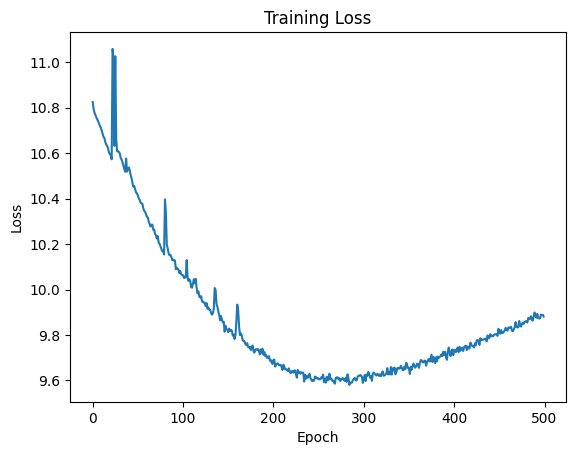

In [77]:
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

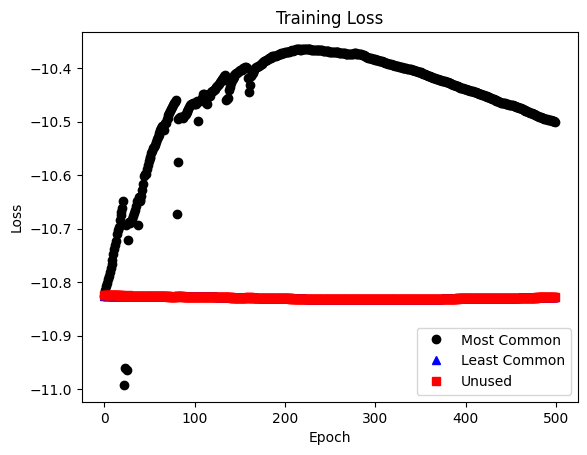

In [81]:
plt.plot(token_probs[:,0],'ko',label='Most Common')
plt.plot(token_probs[:,1],'b^',label='Least Common')
plt.plot(token_probs[:,2],'rs',label='Unused')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()
#